## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [1]:
import numpy as np
import cv2
import glob
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
# %matplotlib qt
%matplotlib inline

## Camera Calibration

### 1. Have the camera matrix and distortion coefficients been computed correctly and checked on one of the calibration images as a test?



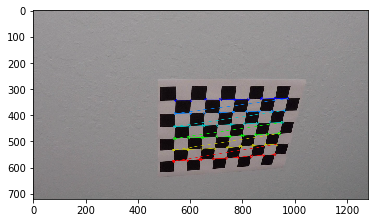

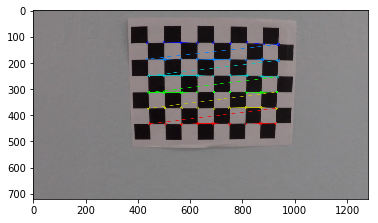

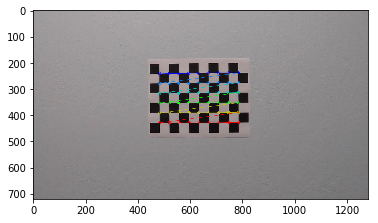

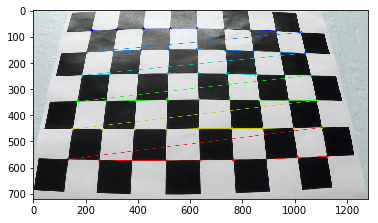

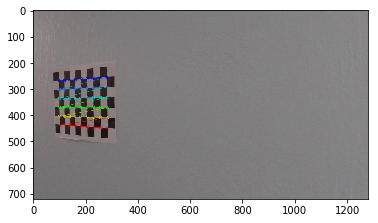

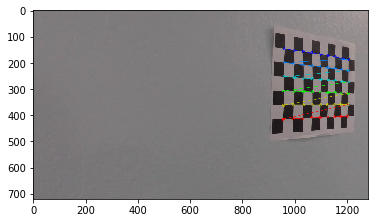

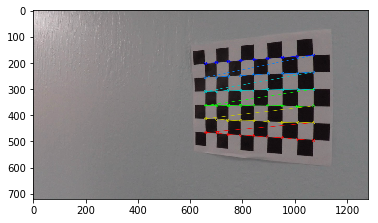

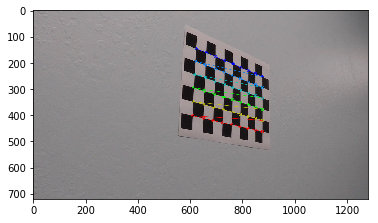

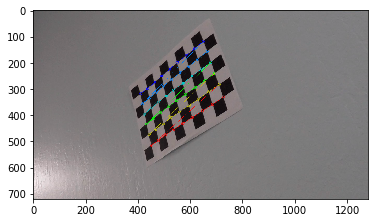

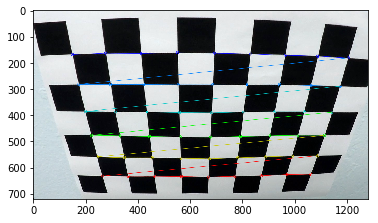

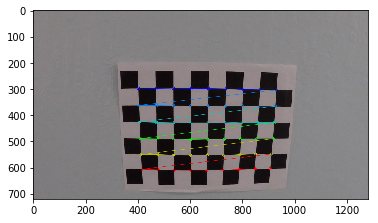

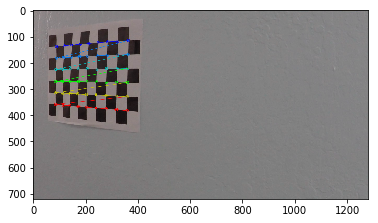

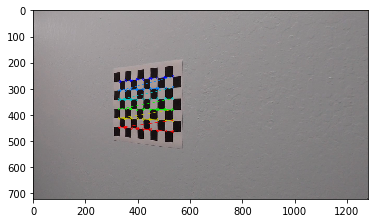

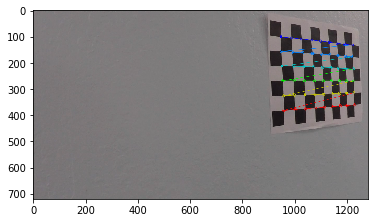

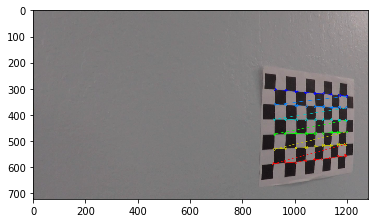

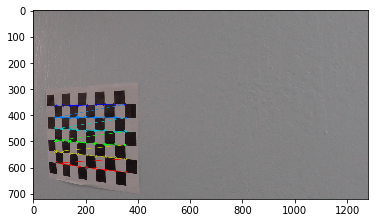

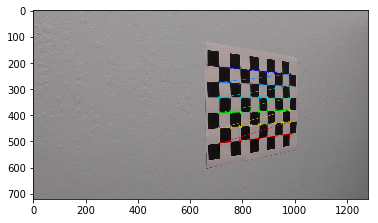

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure()
        plt.imshow(img)

cv2.destroyAllWindows()

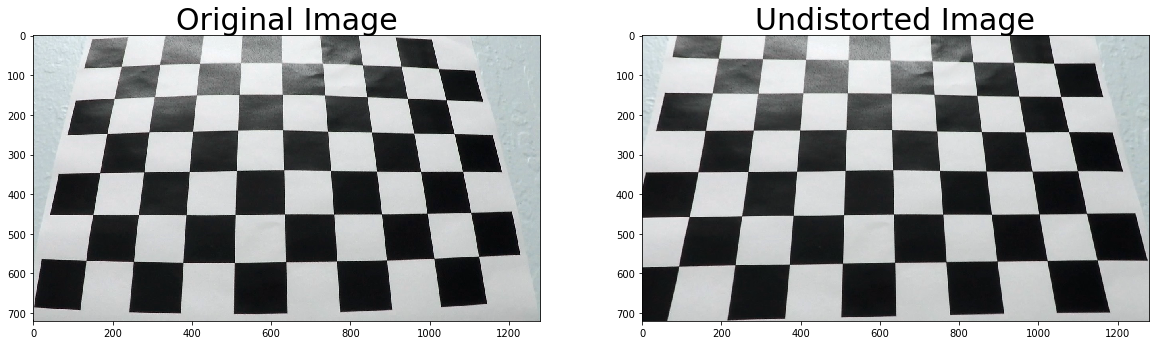

In [3]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( ".wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

#### Define function for apply distortion

In [4]:
def correctDistortion(img):
    ''' correct Distortion '''
    return cv2.undistort(img, mtx, dist, None, mtx)

## Pipeline (Test images)

------ 

### 1. Example for Apply the distortion correction

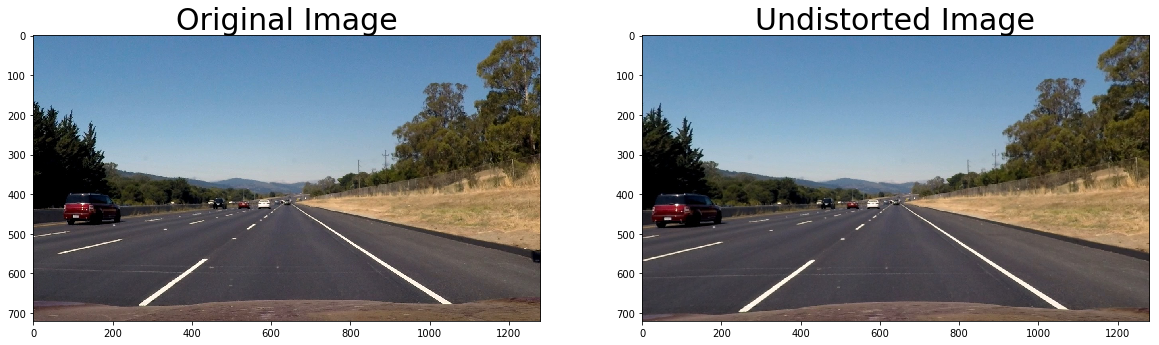

In [5]:
img = cv2.imread('./test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = correctDistortion(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### 2. Has a binary image been created using color transforms, gradients or other methods?

### 2.1 color transofrmation and thresholds.


In [71]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def processImg(rbgImg, s_thresh=(200, 255), sx_thresh=(60, 100)):
#      s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(rbgImg)
    
    imshape = img.shape
    masked_edges = region_of_interest(img,\
                                      np.array(\
                                               [[(40,imshape[0]),\
                                                 (imshape[1]/2-20, imshape[0]*3/5), \
                                                 (imshape[1]/2, imshape[0]*3/5), \
                                                 (imshape[1]-20,imshape[0])]], dtype=np.int32)
                                     )
    
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    # Take the derivative in x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=3) 
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=3) 
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

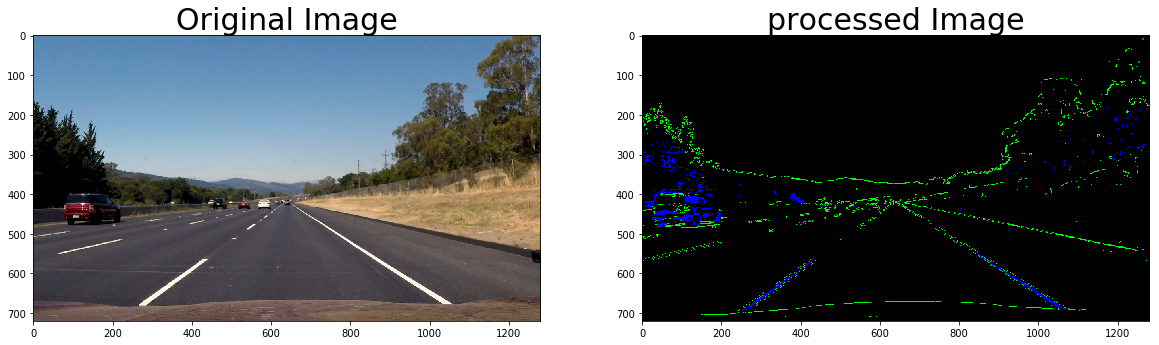

In [72]:
img = cv2.imread('./test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = correctDistortion(img)
ori_img = np.copy(dst)
dst = processImg(dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('processed Image', fontsize=30)

### 2.2 Perspective transform


In [51]:
srcPt = np.float32([
    [585, 460],
    [203, 720],
    [1127, 720],
    [695, 460]
])

dstPt = np.float32([
    [320, 0],
    [320, 720],
    [960, 720],
    [960, 0]
])

M = cv2.getPerspectiveTransform(srcPt, dstPt)
Minv = cv2.getPerspectiveTransform(dstPt, srcPt)

def transformImgToBirdEyeView(img):
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

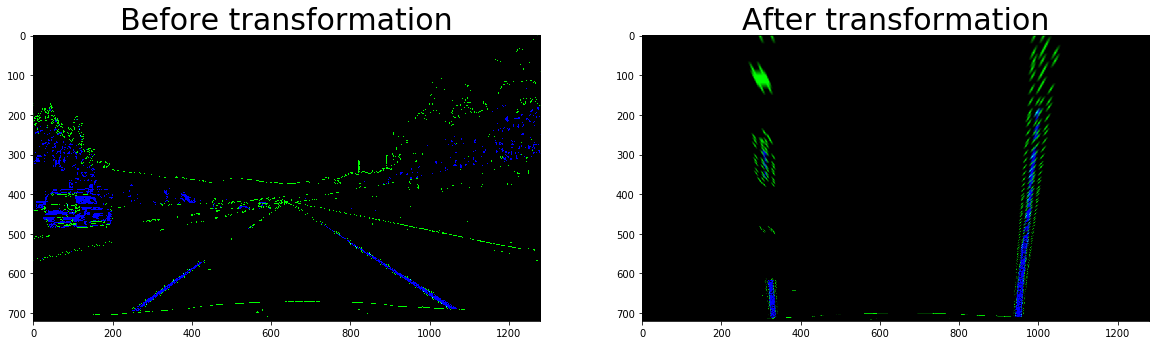

In [52]:
bridEyeDst_HSL = transformImgToBirdEyeView(dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(dst)
ax1.set_title('Before transformation', fontsize=30)
ax2.imshow(bridEyeDst_HSL)
ax2.set_title('After transformation', fontsize=30)

#### To gray scale

(720, 1280)


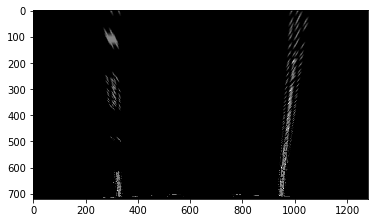

In [53]:
bridEyeDst = np.array(bridEyeDst_HSL[:,:,0] +bridEyeDst_HSL[:,:,1]+bridEyeDst_HSL[:,:,2]).reshape((bridEyeDst_HSL.shape[0],bridEyeDst_HSL.shape[1]))
grayDst = np.array(dst[:,:,0] +dst[:,:,1]+dst[:,:,2]).reshape((dst.shape[0],dst.shape[1]))
grayDst = np.dstack((grayDst,grayDst,grayDst))
print(bridEyeDst.shape)
plt.imshow(bridEyeDst, cmap=plt.get_cmap('gray'))

### 2.3 Line fitting


#### 2.3.1 find Line points

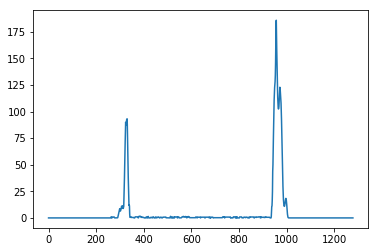

In [54]:
binary_warped = bridEyeDst
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

(720, 1280)


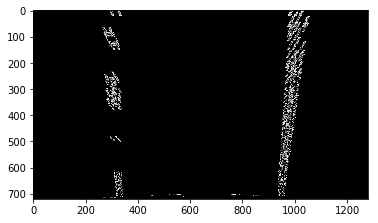

In [55]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
single_channel_gray = binary_warped*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(int(histogram.shape[0]/2))
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print(single_channel_gray.shape)
plt.imshow(out_img)

In [56]:
gray_img = out_img
out_img = np.copy(gray_img)
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

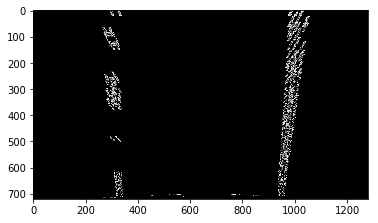

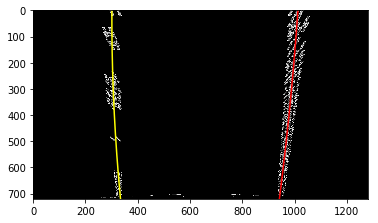

In [57]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure()
plt.imshow(gray_img)
plt.figure()

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(gray_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [58]:

warp_zero = np.zeros_like(single_channel_gray).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.array(np.hstack((pts_left, pts_right)), np.int32)



In [59]:
ori_img.dtype

dtype('uint8')

(1, 3, 2)


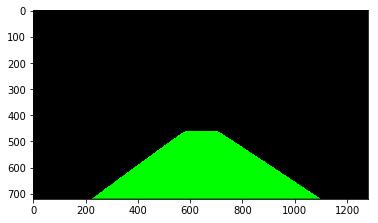

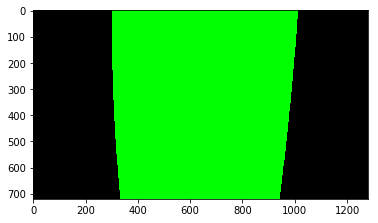

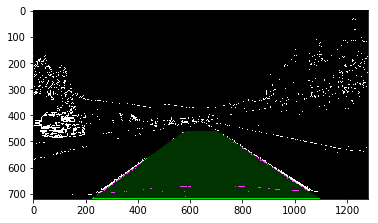

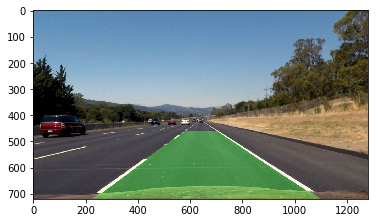

In [60]:

# cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
triangle = np.array([ [[10,30], [40,80], [10,90]] ], np.int32)
print(triangle.shape)
cv2.fillPoly(color_warp, pts, (0, 255, 0))

newwarp = cv2.warpPerspective(color_warp, Minv, (gray_img.shape[1], gray_img.shape[0])) 

res = cv2.addWeighted(np.array(grayDst,np.float32), 1, np.array(newwarp,np.float32), 0.3, 0.0)
rgb_weigthed = cv2.addWeighted(np.array(ori_img,np.uint8), 1, np.array(newwarp,np.uint8), 0.3, 0.0)

plt.imshow(newwarp)
plt.figure()
plt.imshow(color_warp)
plt.figure()
plt.imshow(res)
plt.figure()
plt.imshow(rgb_weigthed)

In [61]:
def calCurvature(yVals, x):
    y_eval = np.max(yVals)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    fit_cr = np.polyfit(ploty*ym_per_pix, x*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
#     print(curverad, 'm')
    return curverad

In [62]:
def findOffCenter(img, pts):
    '''
        Find how far the car off the center 
    '''
    pts = pts[0]
    position = img.shape[1]/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    xm_per_pix = 3.7/700 
    res = (position - center)*xm_per_pix
#     print(res, 'm')
    return res

def drawOffCenter(rgbImg, position):
    rgbImg = rgbImg.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
#     print("I draw " , text)
    cv2.putText(rgbImg,text,(400,150), font, 1,(255,255,255),2)
    return rgbImg
    

In [63]:
position = rgb_weigthed.shape[1]/2
pts[0].shape

(1440, 2)

In [64]:
def drawCurvature(rgbImg, curvature):    
    rgbImg = rgbImg.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(rgbImg,text,(400,100), font, 1,(255,255,255),2)
    return rgbImg

In [65]:
leftCur = calCurvature(ploty, left_fitx)
rightCur = calCurvature(ploty, right_fitx)
offCenter = findOffCenter(rgb_weigthed, pts)

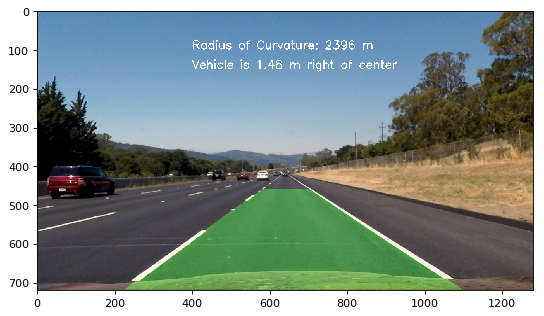

In [66]:
rgb_weigthed = drawCurvature(rgb_weigthed, leftCur)
rgb_weigthed = drawOffCenter(rgb_weigthed, offCenter)
plt.figure(figsize=(8, 6), dpi=80,)
plt.imshow(rgb_weigthed)

### Wrap all steps into 

In [67]:
def pipeline(img, M, Minv):
    ''' 
        M = cv2.getPerspectiveTransform(srcPt, dstPt)
        Minv = cv2.getPerspectiveTransform(dstPt, srcPt)
        
        return the processed img 
    '''
    #  Apply the distortion correction
    dst = correctDistortion(img)
    # apply color transofrmation and thresholds
    dst = processImg(dst)
    # apply perspective transform 
    bridEyeDst_HSL = transformImgToBirdEyeView(dst)
    
    #to gray scale
    bridEyeDst = np.array(bridEyeDst_HSL[:,:,0] +bridEyeDst_HSL[:,:,1]+bridEyeDst_HSL[:,:,2]).reshape((bridEyeDst_HSL.shape[0],bridEyeDst_HSL.shape[1]))
    grayDst = np.array(dst[:,:,0] +dst[:,:,1]+dst[:,:,2]).reshape((dst.shape[0],dst.shape[1]))
    grayDst = np.dstack((grayDst,grayDst,grayDst))
    
    # Lane fitting 
    binary_warped = bridEyeDst
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    single_channel_gray = binary_warped*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(int(histogram.shape[0]/2))
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    gray_img = out_img
    out_img = np.copy(gray_img)
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = np.zeros_like(single_channel_gray).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.array(np.hstack((pts_left, pts_right)), np.int32)
    
    triangle = np.array([ [[10,30], [40,80], [10,90]] ], np.int32)
    cv2.fillPoly(color_warp, pts, (0, 255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (gray_img.shape[1], gray_img.shape[0])) 

    res = cv2.addWeighted(np.array(grayDst,np.float32), 1, np.array(newwarp,np.float32), 0.3, 0.0)
    rgb_weigthed = cv2.addWeighted(np.array(img,np.uint8), 1, np.array(newwarp,np.uint8), 0.3, 0.0)

#     leftCur = calCurvature(ploty, left_fitx)
#     rightCur = calCurvature(ploty, right_fitx)
#     offCenter = findOffCenter(rgb_weigthed, pts)
    
#     rgb_weigthed = drawCurvature(rgb_weigthed, leftCur)
#     rgb_weigthed = drawOffCenter(rgb_weigthed, offCenter)
    
    return rgb_weigthed

def pipeline_min(img):
    returnImg = pipeline(img, M, Minv)
    plt.imshow(resImg)
    return returnImg

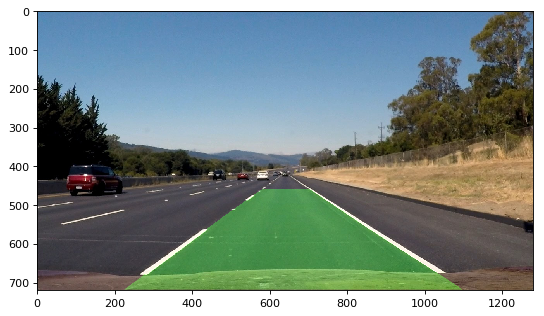

In [68]:
mimg = cv2.imread('./test_images/straight_lines2.jpg')
mimg = cv2.cvtColor(mimg, cv2.COLOR_BGR2RGB)
resImg = pipeline(mimg, M, Minv)
plt.figure(figsize=(8, 6), dpi=80,)
plt.imshow(resImg)

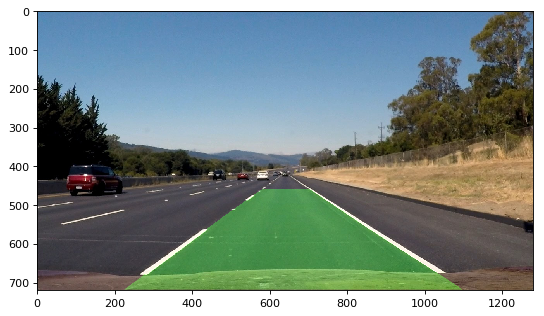

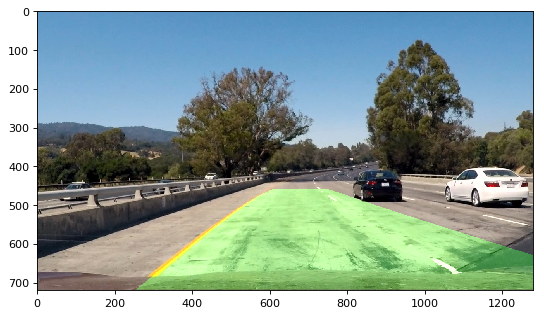

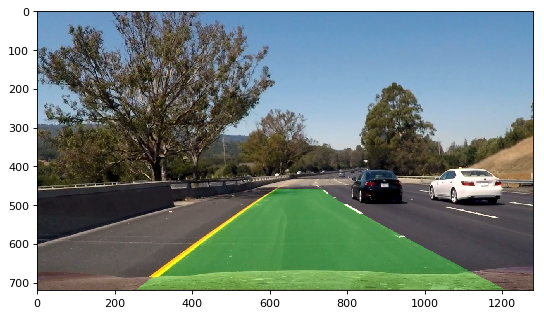

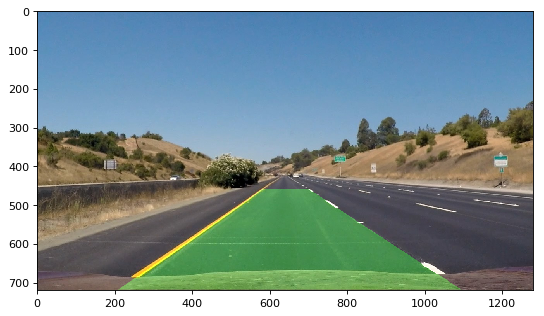

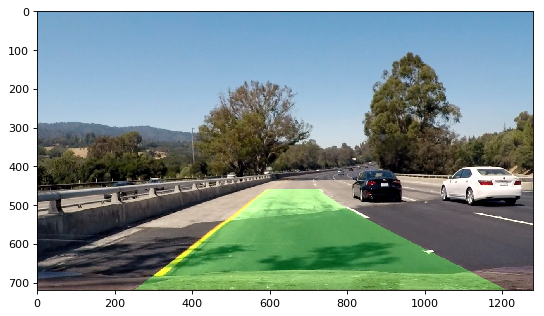

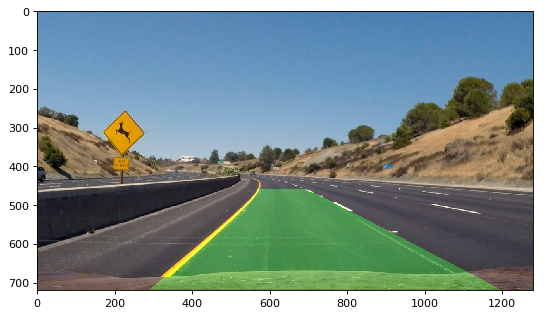

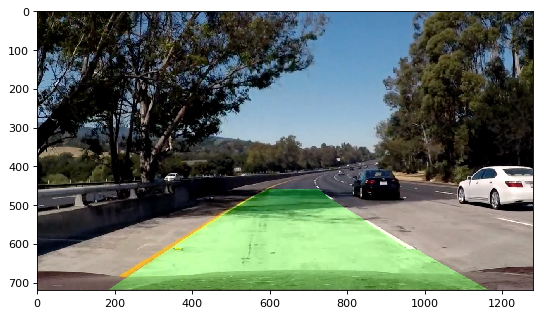

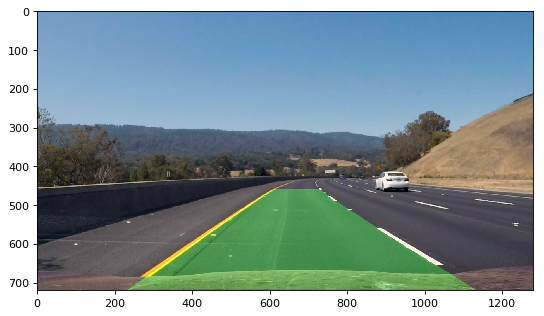

In [69]:
import os
theTestImgs = os.listdir("./test_images")
for file in theTestImgs:
    mimg = cv2.imread('./test_images/'+file)
    mimg = cv2.cvtColor(mimg, cv2.COLOR_BGR2RGB)
    resImg = pipeline(mimg, M, Minv)
    plt.figure(figsize=(8, 6), dpi=80,)
    plt.imshow(resImg)

## Process video

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<04:50,  4.34it/s]

  0%|          | 2/1261 [00:00<04:37,  4.53it/s]

  0%|          | 3/1261 [00:00<04:18,  4.87it/s]

  0%|          | 4/1261 [00:00<04:04,  5.14it/s]

  0%|          | 5/1261 [00:00<03:54,  5.36it/s]

  0%|          | 6/1261 [00:01<03:48,  5.49it/s]

  1%|          | 7/1261 [00:01<03:49,  5.48it/s]

  1%|          | 8/1261 [00:01<03:55,  5.32it/s]

  1%|          | 9/1261 [00:01<03:50,  5.44it/s]

  1%|          | 10/1261 [00:01<03:45,  5.54it/s]

  1%|          | 11/1261 [00:02<03:41,  5.63it/s]

  1%|          | 12/1261 [00:02<03:54,  5.33it/s]

  1%|          | 13/1261 [00:02<04:19,  4.82it/s]

  1%|          | 14/1261 [00:02<04:22,  4.75it/s]

  1%|          | 15/1261 [00:02<04:43,  4.40it/s]

  1%|▏         | 16/1261 [00:03<04:53,  4.24it/s]

  1%|▏         | 17/1261 [00:03<04:54,  4.22it/s]

  1%|▏         | 18/1261 [00:03<04:54,  4.22it/s]

  2%|▏         | 19/1261 [00:03<05:16,  3.93it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 7min 52s, sys: 6.3 s, total: 7min 58s
Wall time: 4min 28s


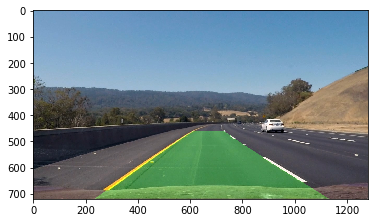

In [70]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_min) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_video_white.mp4
[MoviePy] Writing video challenge_video_white.mp4




  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 1/485 [00:00<01:24,  5.74it/s]

  0%|          | 2/485 [00:00<01:27,  5.53it/s]

  1%|          | 3/485 [00:00<01:26,  5.58it/s]

  1%|          | 4/485 [00:00<01:26,  5.57it/s]

  1%|          | 5/485 [00:00<01:26,  5.58it/s]

  1%|          | 6/485 [00:01<01:23,  5.77it/s]

  1%|▏         | 7/485 [00:01<01:19,  5.98it/s]

  2%|▏         | 8/485 [00:01<01:18,  6.07it/s]

  2%|▏         | 9/485 [00:01<01:18,  6.10it/s]

  2%|▏         | 10/485 [00:01<01:27,  5.41it/s]

  2%|▏         | 11/485 [00:02<01:33,  5.06it/s]

  2%|▏         | 12/485 [00:02<01:26,  5.46it/s]

  3%|▎         | 13/485 [00:02<01:25,  5.51it/s]

  3%|▎         | 14/485 [00:02<01:21,  5.78it/s]

  3%|▎         | 15/485 [00:02<01:19,  5.90it/s]

  3%|▎         | 16/485 [00:02<01:18,  5.95it/s]

  4%|▎         | 17/485 [00:02<01:17,  6.00it/s]

  4%|▎         | 18/485 [00:03<01:16,  6.08it/s]

  4%|▍         | 19/485 [00:03<01:16,  6.08it/s]

  4%|▍         |

TypeError: expected non-empty vector for x

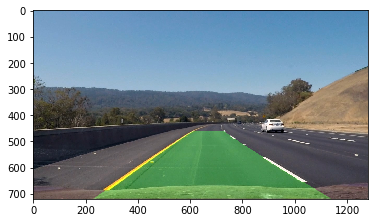

In [48]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'challenge_video_white.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline_min) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)